In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_excel('沪深300.xlsx', header=3)
df = df.dropna(axis = 1, how = 'all')

bool_cols = []
for column in df.columns:
    if df[column].dtype == 'bool':
        bool_cols.append(column)
        
df.drop(['tech_MA5', 'tech_MA20'], axis=1, inplace=True)

for column in df.columns:
    if df[column].isnull().any() and column not in bool_cols:
        df[column].fillna(df[column].mean(), inplace=True)
df['trend'] = (df['close'] < df['close'].shift(-1))
df = df.iloc[1:,]
df

,Date,open,high,low,close,volume,amt,dealnum,adjfactor,turn,...,stage_high,stage_low,up_days,down_days,breakout_ma,breakdown_ma,history_high_days,history_low_days,bull_bear_ma,trend
1,2012-05-29,2.602,2.661,2.602,2.644,714949008.0,1.875593e+09,11432,1.000000,6.936538,...,True,True,1.0,0.0,False,False,2,1,False,False
2,2012-05-30,2.642,2.647,2.633,2.636,265887198.0,7.017258e+08,5532,1.000000,2.595794,...,True,True,0.0,1.0,False,False,2,1,False,False
3,2012-05-31,2.621,2.645,2.613,2.630,178155984.0,4.681931e+08,4662,1.000000,1.747313,...,True,False,0.0,2.0,False,False,1,0,False,False
4,2012-06-01,2.629,2.660,2.620,2.630,179350035.0,4.734772e+08,5189,1.000000,1.766249,...,False,False,0.0,0.0,False,False,0,0,False,False
5,2012-06-04,2.601,2.604,2.555,2.558,546074272.0,1.413414e+09,7566,1.000000,5.559705,...,False,False,0.0,1.0,False,False,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,2025-03-27,4.011,4.050,3.995,4.027,801525164.0,3.224973e+09,70576,1.207793,0.941116,...,False,False,1.0,0.0,False,False,0,0,False,False
3119,2025-03-28,4.027,4.029,4.000,4.008,704304791.0,2.826193e+09,59846,1.207793,0.828821,...,False,False,0.0,1.0,False,False,0,0,False,False
3120,2025-03-31,4.004,4.024,3.969,3.984,902172863.0,3.600807e+09,110122,1.207793,1.060626,...,False,False,0.0,2.0,False,False,0,0,False,False
3121,2025-04-01,3.988,4.003,3.979,3.982,615015541.0,2.452333e+09,58348,1.207793,0.721766,...,False,False,0.0,3.0,False,False,0,0,False,False


In [17]:
np.random.seed(42)

# Parameters
WINDOW_SIZE = 20
TARGET_COLUMN = 'trend'
FEATURES = [col for col in df.columns if col not in ['Date', 'trend']]
#FEATURES = ['close']
#FEATURES = ['open', 'high', 'low', 'close', 'volume', 'MACD', 'RSI', 'up_days', 'down_days', 'history_high_days', 'history_low_days']
BOOL_FEATURES = [col for col in FEATURES if df[col].dtype == 'bool']
NUM_FEATURES = [col for col in FEATURES if col not in BOOL_FEATURES]
TEST_SIZE = 0.2

Create lagged features

In [18]:
def create_lagged_features(df, target_col, features, window_size):
    lagged_data = []
    for i in range(window_size, len(df)):
        lagged_features = df[features].iloc[i-window_size:i].values.flatten()
        target = df[target_col].iloc[i]
        lagged_data.append(np.append(lagged_features, target))
    
    feature_names = []
    for lag in range(window_size):
        for feature in features:
            feature_names.append(f"{feature}_lag_{lag+1}")
    feature_names.append(target_col)  
    
    return pd.DataFrame(lagged_data, columns=feature_names)

Evaluation

In [19]:
# Metrics calculation
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

Backtest

In [20]:
def backtest_strategy(df):
    # Calculate daily returns based on 'close' prices
    df['daily_return'] = df['close'].pct_change()  # Percentage change in close prices
    
    # Initialize strategy returns array
    strategy_returns = []
    for i in range(len(df) - 1):  # Exclude the last row since no next-day action
        if df.loc[i, 'preds'] == 1:
            # If prediction is 1, assume we buy at today's close and sell at tomorrow's close
            strategy_return = (df.loc[i + 1, 'close'] - df.loc[i, 'close']) / df.loc[i, 'close']
        else:
            # If prediction is 0, assume we sell at today's close and buy at tomorrow's close
            strategy_return = (df.loc[i, 'close'] - df.loc[i + 1, 'close']) / df.loc[i, 'close']
        strategy_returns.append(strategy_return)
    
    # Add strategy returns to the DataFrame
    df = df.iloc[:-1]  # Exclude the last row since we can't calculate returns for it
    df['strategy_return'] = strategy_returns
    
    # Calculate cumulative returns for the strategy and index
    df['strategy_net_value'] = (1 + df['strategy_return']).cumprod()
    df['index_net_value'] = (1 + df['daily_return']).cumprod()
    
    # Calculate metrics
    total_days = len(df)
    annualized_return = (df['strategy_net_value'].iloc[-1]) ** (252 / total_days) - 1  # 252 trading days in a year
    daily_win_rate = (df['strategy_return'] > 0).mean()  # Proportion of positive daily returns
    
    df.to_excel('output2.xlsx', index=False)
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['strategy_net_value'], label='Strategy Net Value', color='blue')
    plt.plot(df['date'], df['index_net_value'], label='Index Net Value (510300.SH)', color='orange')
    plt.title('Strategy vs Index Net Value')
    plt.xlabel('Date')
    plt.ylabel('Net Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # print results
    print('Annualized Return:', annualized_return)
    print('Daily Win Rate:', daily_win_rate)
    # Return results
    results = {
        'annualized_return': annualized_return,
        'daily_win_rate': daily_win_rate,
        'strategy_net_value': df['strategy_net_value'],
        'index_net_value': df['index_net_value']
    }
    return results

Main

[0]	test-logloss:0.69096
[1]	test-logloss:0.68935
[2]	test-logloss:0.68981
[3]	test-logloss:0.69308
[4]	test-logloss:0.69187
[5]	test-logloss:0.69281
[6]	test-logloss:0.69256
[7]	test-logloss:0.69558
[8]	test-logloss:0.69558
[9]	test-logloss:0.69261
[10]	test-logloss:0.68905
[11]	test-logloss:0.68896
[12]	test-logloss:0.68896
[13]	test-logloss:0.68854
[14]	test-logloss:0.69025
[15]	test-logloss:0.69033
[16]	test-logloss:0.69074
[17]	test-logloss:0.69391
[18]	test-logloss:0.69584
[19]	test-logloss:0.69472
[20]	test-logloss:0.69560
[21]	test-logloss:0.69619
[22]	test-logloss:0.69766

Xgboost's performance:
Accuracy: 0.527273
Precision: 0.479319
Recall: 0.732342
F1 Score: 0.579412


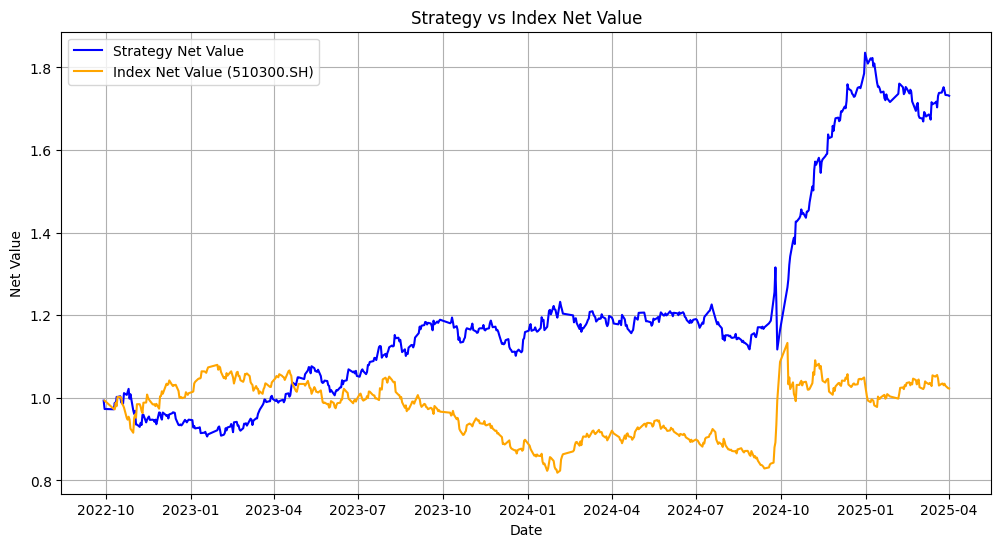

Annualized Return: 0.25731884925514836
Daily Win Rate: 0.5215231788079471



In [21]:
train_size = int(len(df) * (1 - TEST_SIZE))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

lagged_train = create_lagged_features(train_data, TARGET_COLUMN, FEATURES, WINDOW_SIZE)
lagged_test = create_lagged_features(test_data, TARGET_COLUMN, FEATURES, WINDOW_SIZE)

X_train = lagged_train.drop(columns=[TARGET_COLUMN])
y_train = lagged_train[TARGET_COLUMN]
X_test = lagged_test.drop(columns=[TARGET_COLUMN])
y_test = lagged_test[TARGET_COLUMN]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',        
    'tree_method': 'hist',       
    'learning_rate': 0.1,           
    'max_depth': 7,                
    'subsample': 1,               
    'colsample_bytree': 1,       
    'seed': 42                    
}

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)

y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)  
np.save('xgboost_prob_preds.npy', y_pred_prob)

#evaluate the model
print("\nXgboost's performance:")
xgboost_metrics = calculate_metrics(y_test, y_pred)
for metric, value in xgboost_metrics.items():
    print(f"{metric}: {value:.6f}")

# backtest the model
train_size = int(len(df) * (1 - TEST_SIZE))
xgboost_pred_series = pd.Series(y_pred, index=range(train_size+WINDOW_SIZE+1, train_size+WINDOW_SIZE+1 + len(y_pred)))
df['xgboost_preds'] = xgboost_pred_series
xgboost_backtest = df.loc[train_size+WINDOW_SIZE+1:, ['Date', 'close', 'xgboost_preds']]
xgboost_backtest.rename(columns={'xgboost_preds': 'preds', 'Date':'date'}, inplace=True)
xgboost_backtest.reset_index(drop=True, inplace=True)
xgboost_backtest.to_excel('xgboost_output.xlsx', index=False)
backtest_strategy(xgboost_backtest)
print()